# Our implementation (TensorFlow)
[source code](https://github.com/akanametov/neural-style-transfer/tree/main)

In [1]:
# Dependencies
import tensorflow as tf
import numpy as np
import time

# visualization tools
import IPython.display as display
import matplotlib.pyplot as plt
import PIL.Image

## Visualization

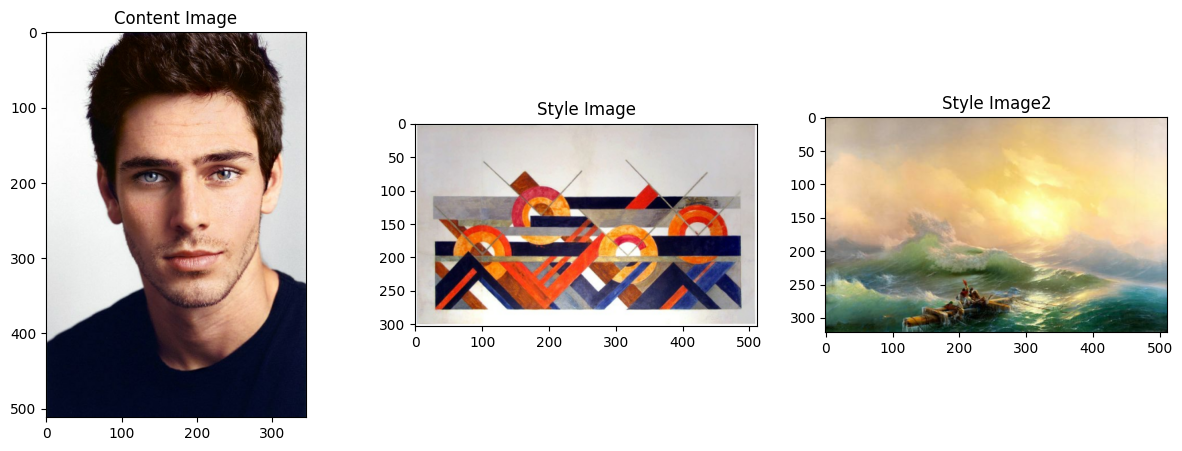

In [3]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

content_image = load_img('/content/content.jpg')
style1_image = load_img('/content/style1.jpg')
style2_image = load_img('/content/style2.jpg')

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 3, 2)
imshow(style1_image, 'Style Image')

plt.subplot(1, 3, 3)
imshow(style2_image, 'Style Image2')


## Constructing the Model

In [17]:
'''Define the gram matrix for calculating style loss later'''

def gram_matrix(img_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', img_tensor, img_tensor)
  input_shape = tf.shape(img_tensor)
  locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  r = result/locations
  return r

In [22]:
'''Create the model with layers in input1: styleLayerNames and in input2: contetnLayerNames
Like the compile class of the source code, this method builds the model'''

def vggO(layer1, layer2):
  ## Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  # output is a list object that contains the output tensor of each layer as specified in the input
  outputs = [vgg.get_layer(name).output for name in layer1]+[vgg.get_layer(name).output for name in layer2]
  ## create the model using Model API
  model = tf.keras.Model([vgg.input], outputs)
  return model


'''Conduct a forward pass of the model, extract and oragnize output of each layer'''
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, content_list, style_list):
    super(StyleContentModel, self).__init__()

    self.vgg = vggO(style_list, content_list)
    self.style_layer_num = len(style_list)
    self.content = content_list
    self.style = style_list
    self.vgg.trainable = False

  def call(self, inputs):
    ## just preprocessing the inputs
    inputs = inputs*255.0
    processed = tf.keras.applications.vgg19.preprocess_input(inputs)
    ## feed inputs and get prediction from vgg
    outputs = self.vgg(processed)

    style_outputs, content_outputs = (outputs[:self.style_layer_num],
                                      outputs[self.style_layer_num:])

    # gram-changed style outputs
    style_outputs = [gram_matrix(s)
                     for s in style_outputs]

    # content_name being the content layer name, value being the output
    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style, style_outputs)}

    return {'content': content_dict, 'style': style_dict}


### Single Style Transfer with Loss

In [23]:
'''MSE loss for style and content. Also takes in style and content loss weights.'''
def total_loss(outputs, extractor, num_content_layers, num_style_layers, style_image, content_image):
    style_targets = extractor(style_image)['style']
    content_targets = extractor(content_image)['content']

    style_weight=1
    content_weight=4

    ## Calculate style loss
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss

    return loss

In [24]:
step_loss_list1 = []
epoch_loss_list1 = []

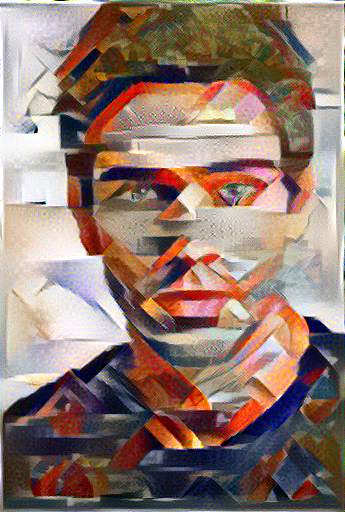

Train step: 700
Total time: 530.4


In [25]:
## turn image into variable
image = tf.Variable(content_image)

## normalize image
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
## define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

## content and style layers
total_variation_weight=30
style_list = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
content_list = ['block5_conv2']

epochs = 7
steps_per_epoch = 100

'''
Train method. takes in content image and content&style layers, update the content image tensor
'''
def train_step(image, content_list, style_list, style_image, content_image):
  extractor = StyleContentModel(content_list, style_list)
  content_layer_num = len(content_list)
  style_layer_num = len(style_list)
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = total_loss(outputs, extractor, content_layer_num, style_layer_num, style_image, content_image)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  optimizer.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

  step_loss_list1.append(loss)

start = time.time()

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image, content_list, style_list, style1_image, content_image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

  epoch_step_start = n*100
  epoch_loss = tf.reduce_mean(step_loss_list1[epoch_step_start:epoch_step_start+steps_per_epoch])
  epoch_loss_list1.append(epoch_loss)

stylized_image_tensor=image
stylized_image=tensor_to_image(image)

end = time.time()
print("Total time: {:.1f}".format(end-start))



In [26]:
'''Saves the stylized output for single style transfer'''

file_name = 'stylized-image-single.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Single Style Transfer - **Face**

In [27]:
stylized_image_tensor=image
stylized_image=tensor_to_image(image)
content_image_PIL=tensor_to_image(content_image)

In [28]:
#change 1

!pip install MTCNN
from mtcnn import MTCNN
from PIL import ImageDraw
import matplotlib.pyplot as plt
import cv2

!pip install dlib
import dlib
import PIL.Image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 15.4 MB/s eta 0:00:00


#### Ver1


In [ ]:
img = np.array(stylized_image.convert('RGB'))
original_image = np.array(content_image_PIL.convert('RGB'))

detector = MTCNN()
detections = detector.detect_faces(original_image)

img_with_dets = original_image.copy()
min_conf = 0.9

#visualize
for face in detections:
    if face['confidence'] >= min_conf:
        x, y, width, height = face['box']
        keypoints = face['keypoints']
        cv2.rectangle(img_with_dets, (x,y), (x+width,y+height), (0,155,255), 2)
        cv2.circle(img_with_dets, (keypoints['left_eye']), 2, (0,155,255), 2)
        cv2.circle(img_with_dets, (keypoints['right_eye']), 2, (0,155,255), 2)
        cv2.circle(img_with_dets, (keypoints['nose']), 2, (0,155,255), 2)
        cv2.circle(img_with_dets, (keypoints['mouth_left']), 2, (0,155,255), 2)
        cv2.circle(img_with_dets, (keypoints['mouth_right']), 2, (0,155,255), 2)

plt.imshow(img_with_dets)

for face in detections:
    if face['confidence'] >= min_conf:
        x, y, width, height = face['box']
        face_img = img[y:y + height, x:x + width]
        face_img = face_img.astype(np.float32) / 255.0  # Normalize to [0, 1]

        if original_image.dtype != np.float32:
            original_image = original_image.astype(np.float32) / 255.0

        original_image[y:y + height, x:x + width] = face_img
        original_image_uint8 = (original_image * 255).astype(np.uint8)
        result_img = PIL.Image.fromarray(original_image_uint8)
        # background
        plt.figure(figsize=(10, 10))
        plt.imshow(result_img)
        plt.axis('off')
        plt.show()
        break

#### Ver 2: dlib

1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 130ms/step


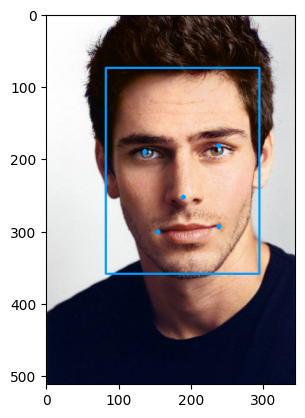

In [31]:
img = np.array(stylized_image.convert('RGB'))
original_image = np.array(content_image_PIL.convert('RGB'))

# imgW, imgH,_ = original_image.shape


predictor_path = "/content/shape_predictor_68_face_landmarks.dat"
face_detector = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor(predictor_path)
detector = MTCNN()
detections = detector.detect_faces(original_image)
img_with_dets = original_image.copy()
min_conf = 0.9

#visualize
for face in detections:
    if face['confidence'] >= min_conf:
        x, y, width, height = face['box']
        keypoints = face['keypoints']
        cv2.rectangle(img_with_dets, (x,y), (x+width,y+height), (0,155,255), 2)
        cv2.circle(img_with_dets, (keypoints['left_eye']), 2, (0,155,255), 2)
        cv2.circle(img_with_dets, (keypoints['right_eye']), 2, (0,155,255), 2)
        cv2.circle(img_with_dets, (keypoints['nose']), 2, (0,155,255), 2)
        cv2.circle(img_with_dets, (keypoints['mouth_left']), 2, (0,155,255), 2)
        cv2.circle(img_with_dets, (keypoints['mouth_right']), 2, (0,155,255), 2)

plt.imshow(img_with_dets)


(-0.5, 344.5, 511.5, -0.5)

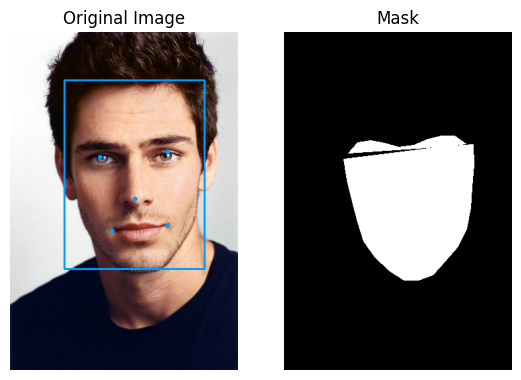

In [32]:
dlib_rect = dlib.rectangle(left=x, top=y, right=x + width, bottom=y + height)
landmarks = landmark_predictor(img_with_dets, dlib_rect)

# Collect coordinates
face_outline = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(0, 27)], dtype=np.int32)

# Create a mask
mask = np.zeros(img_with_dets.shape[:2], dtype=np.uint8)

# Draw a filled polygon on the mask using the face outline
cv2.fillPoly(mask, [face_outline], 255)


#visualization
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(img_with_dets)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.axis('off')

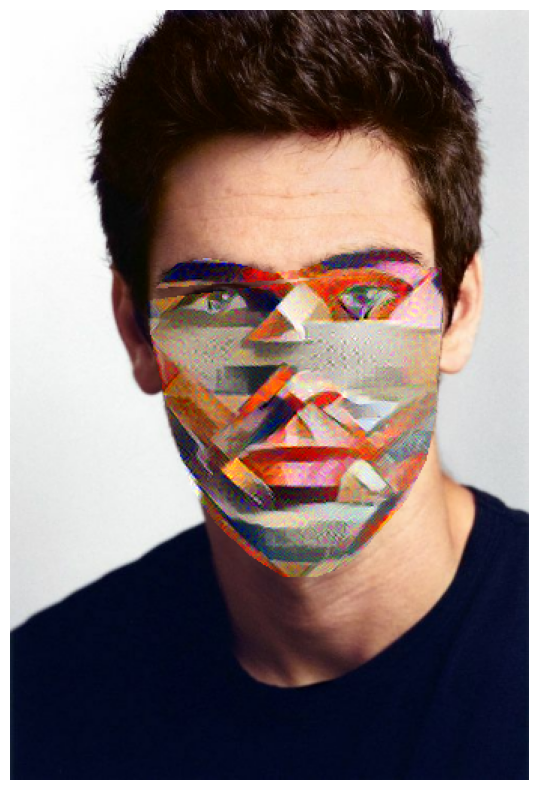

In [33]:
for face in detections:
  output_image = np.zeros_like(img)

# Iterate through each pixel in the image
  for y in range(img.shape[0]):
     for x in range(img.shape[1]):
        if mask[y, x] == 255:  # Pixel is part of the face
            output_image[y, x] = img[y, x]  # Copy face pixel
        else:
            output_image[y, x] = original_image[y,x]  # Set non-face pixels to content image

plt.figure(figsize=(10, 10))
plt.imshow(output_image)
plt.axis('off')
plt.show()

#### Ver 3: mediapipe


In [34]:
!pip install mediapipe opencv-python
import mediapipe as mp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 36.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


(-0.5, 344.5, 511.5, -0.5)

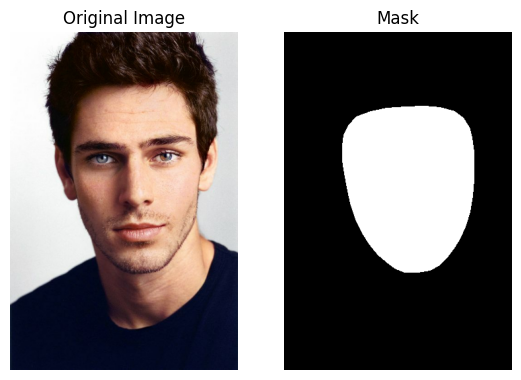

In [35]:
mp_face_mesh = mp.solutions.face_mesh
drawing_utils = mp.solutions.drawing_utils

# Initialize Face Mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5)

# Load an image
img = np.array(stylized_image.convert('RGB'))
original_image = np.array(content_image_PIL.convert('RGB'))
# Process the image
results = face_mesh.process(original_image)

landmark_coordinates = []

if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        # Collect landmarks and update min/max coordinates
        for landmark in face_landmarks.landmark:
            x = int(landmark.x * original_image.shape[1])
            y = int(landmark.y * original_image.shape[0])
            landmark_coordinates.append((x, y))

# Release resources
face_mesh.close()
img_with_dets = original_image.copy()

# Create a mask
mask = np.zeros(img_with_dets.shape[:2], dtype=np.uint8)

points = np.array(landmark_coordinates, dtype=np.int32)
hull = cv2.convexHull(points)
cv2.fillPoly(mask, [hull], 255)

#visualization
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(img_with_dets)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.axis('off')

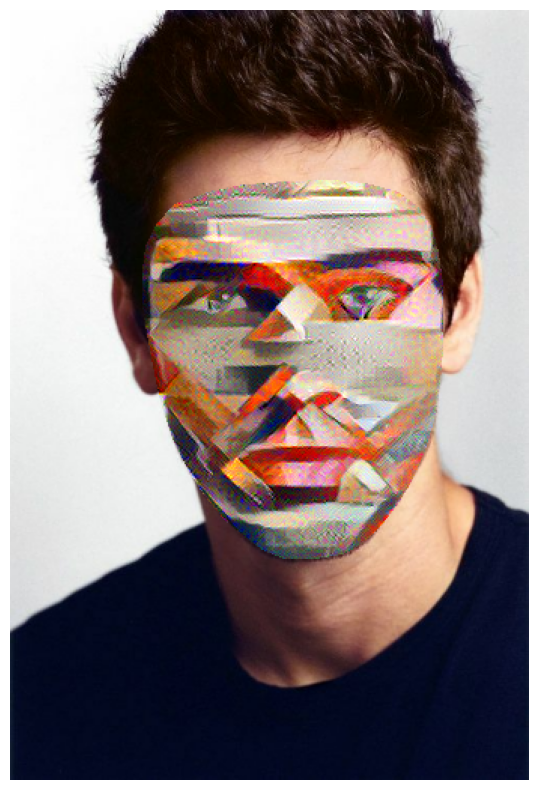

In [36]:
output_image = np.zeros_like(img)

# Iterate through each pixel in the image
for y in range(img.shape[0]):
    for x in range(img.shape[1]):
      if mask[y, x] == 255:  # Pixel is part of the face
          output_image[y, x] = img[y, x]  # Copy face pixel
      else:
          output_image[y, x] = original_image[y,x]  # Set non-face pixels to the same as original image

plt.figure(figsize=(10, 10))
plt.imshow(output_image)
plt.axis('off')
plt.show()

### Multi Style Transfer

In [37]:
def multi_total_loss(outputs, extractor, num_content_layers, num_style_layers, style1_image, style2_image, content_image):
    ## outputs from each style
    style1_targets = extractor(style1_image)['style']
    style2_targets = extractor(style2_image)['style']
    content_targets = extractor(content_image)['content']

    relative_weight = [0.5, 0.5]
    relative_weight1 = relative_weight[0]
    relative_weight2 = relative_weight[1]

    style_weight=1
    content_weight=4
    ## outputs = extractor(content_image); outputs style and content output of the content
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    ## tf.add_n is element-wise addition
    ## style_loss
    style1_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style1_targets[name])**2)
                           for name in style_outputs.keys()])
    style1_loss *= style_weight / num_style_layers

    ## style2_loss
    style2_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style2_targets[name])**2)
                           for name in style_outputs.keys()])
    style2_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    loss = (relative_weight1 * style1_loss + relative_weight2 * style2_loss) + content_loss
    return loss

In [38]:
step_loss_list2 = []
epoch_loss_list2 = []

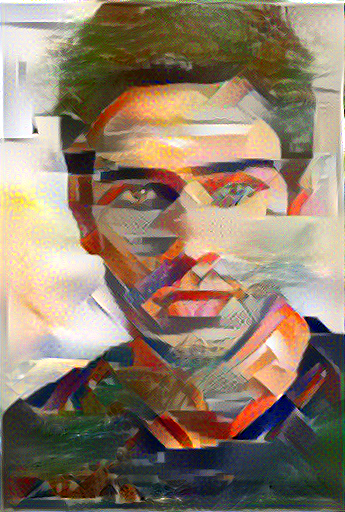

Train step: 700
Total time: 592.5


In [47]:
## turn image into variable
image = tf.Variable(content_image)

## normalize image
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
## define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# parameters
total_variation_weight=30
style_list = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
content_list = ['block5_conv2']

## experiment stuff
epochs = 7
steps_per_epoch = 100

def train_step(image, content_list, style_list, style1_image, style2_image):
  extractor = StyleContentModel(content_list, style_list)
  content_layer_num = len(content_list)
  style_layer_num = len(style_list)
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = multi_total_loss(outputs, extractor, content_layer_num, style_layer_num, style1_image, style2_image, image)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  optimizer.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))
  step_loss_list2.append(loss)

start = time.time()

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image, content_list, style_list, style1_image, style2_image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  epoch_step_start = n*100
  epoch_loss = tf.reduce_mean(step_loss_list2[epoch_step_start:epoch_step_start+steps_per_epoch])
  epoch_loss_list2.append(epoch_loss)

end = time.time()
print("Total time: {:.1f}".format(end-start))



In [48]:
''' Saves the image'''
file_name = 'stylized-image3-multi.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Multi Style Transfer - Face ver 3

In [49]:
stylized_image_tensor=image
stylized_image=tensor_to_image(image)
content_image_PIL=tensor_to_image(content_image)

(-0.5, 344.5, 511.5, -0.5)

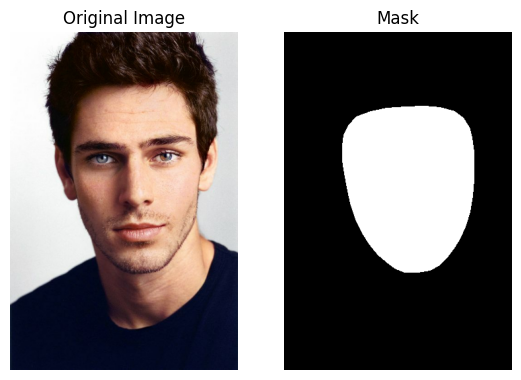

In [50]:
mp_face_mesh = mp.solutions.face_mesh
drawing_utils = mp.solutions.drawing_utils

# Initialize Face Mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5)

# Load an image
img = np.array(stylized_image.convert('RGB'))
original_image = np.array(content_image_PIL.convert('RGB'))
# Process the image
results = face_mesh.process(original_image)

landmark_coordinates = []

if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        # Collect landmarks and update min/max coordinates
        for landmark in face_landmarks.landmark:
            x = int(landmark.x * original_image.shape[1])
            y = int(landmark.y * original_image.shape[0])
            landmark_coordinates.append((x, y))

# Release resources
face_mesh.close()
img_with_dets = original_image.copy()

# Create a mask
mask = np.zeros(img_with_dets.shape[:2], dtype=np.uint8)

points = np.array(landmark_coordinates, dtype=np.int32)
hull = cv2.convexHull(points)
cv2.fillPoly(mask, [hull], 255)

#visualization
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(img_with_dets)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.axis('off')

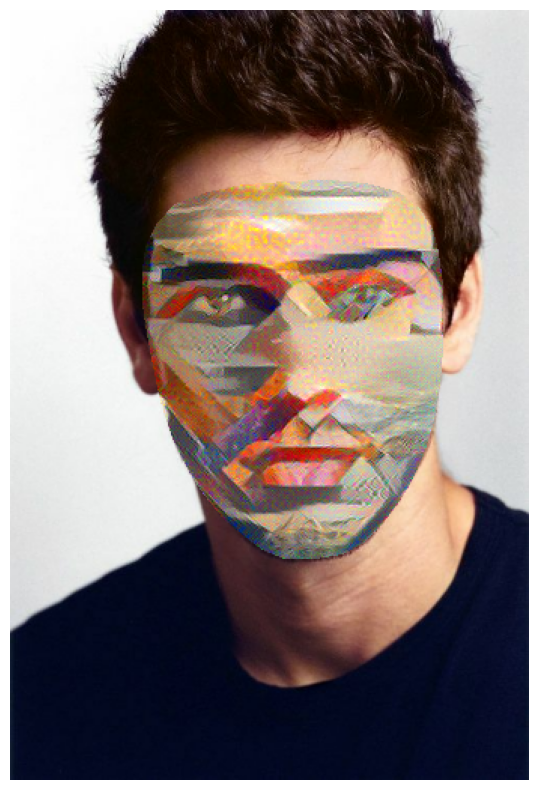

In [51]:
output_image = np.zeros_like(img)

# Iterate through each pixel in the image
for y in range(img.shape[0]):
    for x in range(img.shape[1]):
      if mask[y, x] == 255:  # Pixel is part of the face
          output_image[y, x] = img[y, x]  # Copy face pixel
      else:
          output_image[y, x] = original_image[y,x]  # Set non-face pixels to black

plt.figure(figsize=(10, 10))
plt.imshow(output_image)
plt.axis('off')
plt.show()

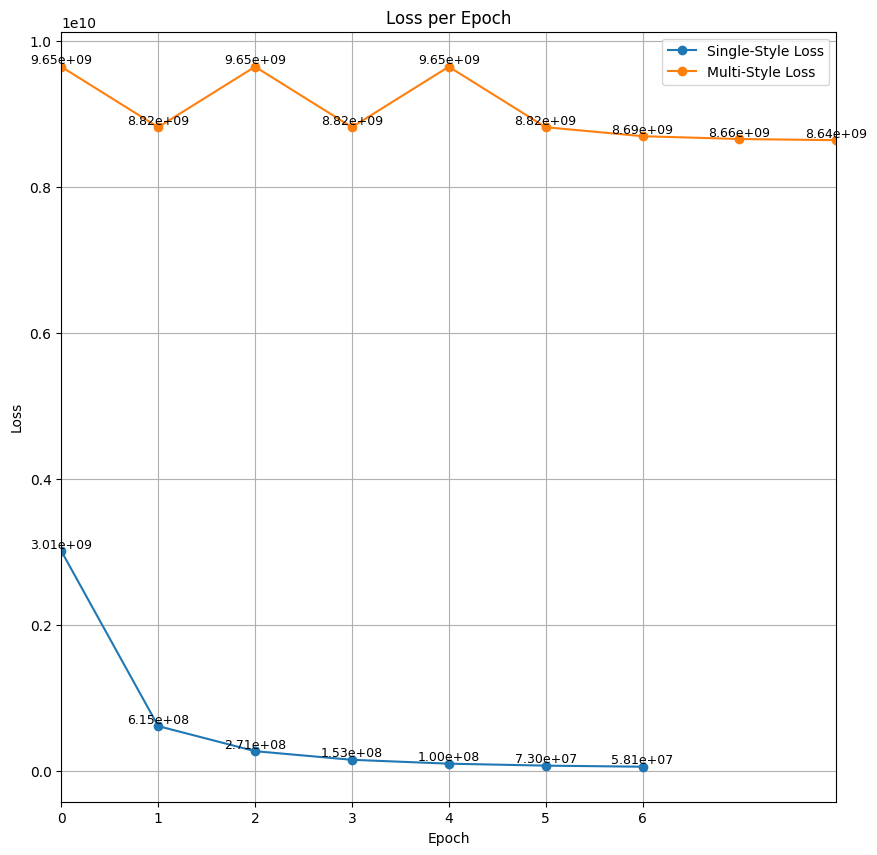

In [52]:
# Plot the epoch loss
plt.figure(figsize=(10, 10))
plt.plot(epoch_loss_list1,marker='o',label='Single-Style Loss')
plt.plot(epoch_loss_list2,marker='o',label='Multi-Style Loss')
plt.xticks([0,1,2,3,4,5,6])
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, len(epoch_loss_list2) - 1)
for i, loss in enumerate(epoch_loss_list1):
    plt.text(i, loss, f'{loss:.2e}', fontsize=9, ha='center', va='bottom')

for i, loss in enumerate(epoch_loss_list2):
    plt.text(i, loss, f'{loss:.2e}', fontsize=9, ha='center', va='bottom')
# Displaying the legend with a larger font size
plt.legend(fontsize=30)

plt.grid(True)
plt.legend()
plt.show()